<a href="https://colab.research.google.com/github/jeochris/DL-Lecture-Study/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='#6629b2'>Reinforcement Learning - A Simple Python Example and a Step Closer to AI with Assisted Q-Learning</font>

This tutorial is based on [here](https://amunategui.github.io/reinforcement-learning/index.html)

Q-learning is a model-free reinforcement learning technique. Specifically, Q-learning can be used to find an optimal action-selection policy for any given (finite) Markov decision process (MDP). 
Machine learning is assumed to be either supervised or unsupervised but a recent new-comer broke the status-quo - reinforcement learning. Supervised and unsupervised approaches require data to model, not reinforcement learning! That’s right, it can explore space with a handful of instructions, analyze its surroundings one step at a time, and build data as it goes along for modeling.

In this walk-through, we’ll use Q-learning to find the shortest path between two areas. It has the ability to embark on a journey with no knowledge of what to do next. This approach requires constant trial and error as it collects data about its surroundings and figures out how to accomplish its goal. This opens up interesting possibilities, what about recording additional information, like environmental details along the way that it may not fully understand until after it reaches its goal? And once reached, could it review that additional data to determine if any of it would have helped it reach its goal faster?

In [1]:
import numpy as np
import pylab as plt
import networkx as nx

In [7]:
# map cell to cell, add circular cell to goal point
# describing edges!
points_list = [(0,1), (1,5), (5,6), (5,4), (1,2), (2,3), (2,7)]

We create a points-list map that represents each direction our bot can take. Using this format allows us to easily create complex graphs but also easily visualize everything with networkx graphs.

**Our starting point is 0, our goal point is 7.**

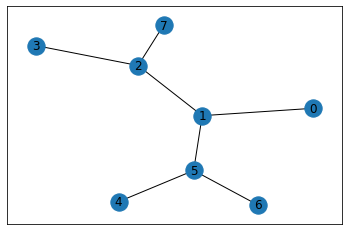

In [8]:
goal = 7

G=nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G,pos)
nx.draw_networkx_edges(G,pos)
nx.draw_networkx_labels(G,pos)
plt.show()

The map shows that point 0 is where our bot will start its journey and point 7 is it’s final goal. The extra added points and false paths are the obstacles the bot will have to contend with. If you look at the top image, we can weave a story into this search - our bot is looking for honey, it is trying to find the hive and avoid the factory (the story-line will make sense in the second half of the article).

We then create the rewards graph - this is the matrix version of our list of points map. We initialize the matrix to be the height and width of our points list (8 in this example) and initialize all values to -1:

In [9]:
## reward setting
# how many points in graph? x points
MATRIX_SIZE = 8

# create matrix x*y = reward matrix 8*8 (initialize with -1)
R = np.matrix(np.ones(shape=(MATRIX_SIZE, MATRIX_SIZE)))
R *= -1
print(R)

[[-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]
 [-1. -1. -1. -1. -1. -1. -1. -1.]]


We then change the values to be 0 if it is a viable path and 100 if it is a goal path

In [10]:
# assign zeros to appropriate paths
# 100 to goal-reaching point (reached 7)
# -1 implies there are no path
for point in points_list:
    print(point)
    if point[1] == goal:
        R[point] = 100
    else:
        R[point] = 0

    if point[0] == goal:
        R[point[::-1]] = 100
    else:
        # reverse of point
        R[point[::-1]]= 0

# add goal point round trip
R[goal,goal]= 100

R

(0, 1)
(1, 5)
(5, 6)
(5, 4)
(1, 2)
(2, 3)
(2, 7)


matrix([[ -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [  0.,  -1.,   0.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,   0.,  -1.,  -1.,  -1., 100.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,   0.,  -1.,  -1.,   0.,  -1.,   0.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,   0.,  -1.,  -1.],
        [ -1.,  -1.,   0.,  -1.,  -1.,  -1.,  -1., 100.]])

To read the above matrix, the y-axis is the state or where your bot is currently located, and the x-axis is your possible next actions. We then build our Q-learning matrix which will hold all the lessons learned from our bot. The Q-learning model uses a transitional rule formula and gamma is the learning parameter

In [33]:
# 8*8 Q-table - 8 states and 8 available movements
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# learning parameter
gamma = 0.8

initial_state = 1

# given current state, find available movements which reward is not negative, which implies there is path
def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state)
print(available_act)

[0 2 5]


In [34]:
# Among available actions, choose randomly one movement
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)
print(action)

2


In [35]:
# updates Q-table with iterative Bellman equation
def update(current_state, action, gamma):
  
  # finds maximum value of Q for given action
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  # if Q[action,] = [1,1,0,0] => multiple max values
  # choose randomly one
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  # otherwise
  else:
      max_index = int(max_index)

  # max value chosen
  max_value = Q[action, max_index]
  
  # Q-table update
  # Q[current_state, action] : time t
  # Q[action, max_index] : time t+1
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  print('max_value', R[current_state, action] + gamma * max_value)
  
  if (np.max(Q) > 0):
    # standardized
    return(np.sum(Q/np.max(Q)*100)) # score of total Q-table sum: as RL works well, Q-table is large
  else:
    return (0)
    
update(initial_state, action, gamma)

max_value 0.0


0

run the training and testing functions that will run the update function 700 times allowing the Q-learning model to figure out the most efficient path:

In [36]:
# Training
scores = []
# 700 scenarios = update Q-table 700 times
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    print ('Score:', str(score))
    
print("Trained Q matrix:")
print(Q/np.max(Q)*100)

max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 0.0
Score: 0
max_value 100.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 80.0
Score: 180.0
max_value 0.0
Score: 180.0
max_value 0.0
Score: 180.0
max_value 0.0
Score: 180.0
max_value 64.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 0.0
Score: 244.0
max_value 80.0
Score: 244.0
max_value 80.0
Score: 324.0
max_value 80.0
Score: 324.0
max_value 0.0
Score: 324.0
max_value 64.0
Score: 388.0
max_value 64.0
Score: 452.0
max_value 64.0
Score: 452.0
max_value 51.2
Score: 503.2
max_value 51.2
Score: 554.4
max_value 40.96000000000001
Score: 595.36
max_value 80.0
Score: 595.36
max_value 80.0
Score: 595.36
max_value 40.96000000000001
Score: 595.36
max_value 51.2
Score: 595.36
max_value 100.0
Score: 695.36
max_value 80.0
Score: 775.36
max_value 64.0
Score: 839.36
max_value 180.0
Score: 510.75555555555553
max_v

Most efficient path:
[0, 1, 2, 7]


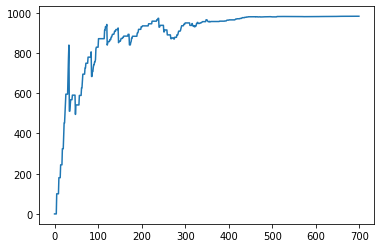

In [37]:
# Testing - Finding most efficient path to arrive at location
current_state = 0
steps = [current_state]

# until reach destination
while current_state != 7:

    # pick biggest action from Q-table
    next_step_index = np.where(Q[current_state,] == np.max(Q[current_state,]))[1]
    
    # also multiple max possible
    if next_step_index.shape[0] > 1:
        next_step_index = int(np.random.choice(next_step_index, size = 1))
    else:
        next_step_index = int(next_step_index)
    
    steps.append(next_step_index)
    current_state = next_step_index

print("Most efficient path:")
print(steps) # found shortest path!

# training plot - score increase
# goes stable later
plt.plot(scores)
plt.show()

We see that the model did correctly find the most efficient path from the starting node 0 to the goal node 7 and took around 400 iterations to converge to a solution.


## <font color='#6629b2'>Version 2.0, with Environmental Details</font>

Now let’s take this a step further, look at the top image again, notice how the factory is surrounded by smoke and the hive, by bees. Let’s assume that bees don’t like smoke or factories, thus there will never be a hive or bees around smoke. What if our bot could record those environmental factors and turn them into actionable insight? Whenever the bot finds smoke it can turn around immediately instead of continuing to the factory, whenever it finds bees, it can stick around and assume the hive it close.

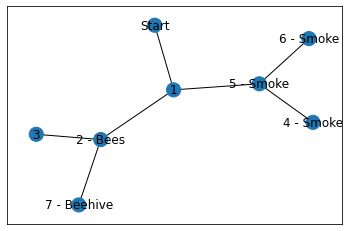

In [38]:
bees = [2]
smoke = [4,5,6]

G=nx.Graph()
G.add_edges_from(points_list)
mapping={0:'Start', 1:'1', 2:'2 - Bees', 3:'3', 4:'4 - Smoke', 5:'5 - Smoke', 6:'6 - Smoke', 7:'7 - Beehive'} 
H=nx.relabel_nodes(G,mapping) 
pos = nx.spring_layout(H)
nx.draw_networkx_nodes(H,pos, node_size=[200,200,200,200,200,200,200,200])
nx.draw_networkx_edges(H,pos)
nx.draw_networkx_labels(H,pos)
plt.show()

# Bees : indicate beehive is nearby => put positive signal
# Smoke : bad signal

We assign node 2 as having bees and nodes 4,5,6 as having smoke. Our Q-learning bot doesn’t know yet that there are bees or smoke there nor does it know that bees are good and smoke bad in finding hives. The bot needs to do another run like we just did, but this time it needs to collect environmental factors.

Here is the new update function with the capability of updating the Q-learning scores when if finds either bees or smoke.

In [41]:
# re-initialize the matrices for new run
Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# additional matrix
enviro_bees = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))
enviro_smoke = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))
 
initial_state = 1

# same (not negative)
def available_actions(state):
    current_state_row = R[state,]
    av_act = np.where(current_state_row >= 0)[1]
    return av_act

available_act = available_actions(initial_state)
print(available_act)

[0 2 5]


In [43]:
def sample_next_action(available_actions_range):
    next_action = int(np.random.choice(available_act,1))
    return next_action

action = sample_next_action(available_act)
print(action)

5


In [44]:
# check whether some environment for given action (next state)
def collect_environmental_data(action):
    found = []
    if action in bees:
        found.append('b')

    if action in smoke:
        found.append('s')
    return (found)

In [45]:
def update(current_state, action, gamma):
  max_index = np.where(Q[action,] == np.max(Q[action,]))[1]
  
  if max_index.shape[0] > 1:
      max_index = int(np.random.choice(max_index, size = 1))
  else:
      max_index = int(max_index)
  max_value = Q[action, max_index]
  
  Q[current_state, action] = R[current_state, action] + gamma * max_value
  print('max_value', R[current_state, action] + gamma * max_value)
  
  # part added
  environment = collect_environmental_data(action)
  if 'b' in environment: 
    # mark
    enviro_bees[current_state, action] += 1
  
  if 's' in environment: 
    enviro_smoke[current_state, action] += 1
  
  if (np.max(Q) > 0):
    return(np.sum(Q/np.max(Q)*100))
  else:
    return (0)

update(initial_state,action,gamma)

max_value 0.0


0

In [46]:
# Training
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)

max_value 0.0
max_value 100.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 180.0
max_value 0.0
max_value 144.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 180.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 115.2
max_value 0.0
max_value 0.0
max_value 0.0
max_value 144.0
max_value 144.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 144.0
max_value 0.0
max_value 115.2
max_value 0.0
max_value 0.0
max_value 144.0
max_value 0.0
max_value 0.0
max_value 244.0
max_value 295.20000000000005
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 144.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 0.0
max_value 144.0
max_value 144.0
max_value 0.0
max_value 115.2
max_value 0.0
max_value 115.2
m

In [48]:
# print environmental matrices
print('Bees Found')
print(enviro_bees)
print('Smoke Found')
print(enviro_smoke)

# current 1, action (next state) 2 => bee found

Bees Found
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 37.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 77.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 43.  0.  0.  0.  0.  0.]]
Smoke Found
[[ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 29.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 85.  0.  0.]
 [ 0.  0.  0.  0. 23.  0. 30.  0.]
 [ 0.  0.  0.  0.  0. 86.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.]]


The environmental matrices show how many bees and smoke the bot found during its journey while searching for the most efficient path to the hive. To make this walk-through simpler, I am assuming two things - we modeled the environmental data and found out that the bees have a positive coefficient on finding hives, and smoke, a negative one. And we are going to reuse the environmental matrix already mapped out for our landscape, a more realistic approach would be to dynamically look at a new environment and assign environmental biases as they are encountered.

In [49]:
# using environment part

Q = np.matrix(np.zeros([MATRIX_SIZE,MATRIX_SIZE]))

# subtract bees with smoke, this gives smoke a negative effect and bee a positive
enviro_matrix = enviro_bees - enviro_smoke

# Get available actions in the current state
available_act = available_actions(initial_state) 

# Sample next action to be performed
action = sample_next_action(available_act)

In [51]:
# same part
# This function updates the Q matrix according to the path selected and the Q 
# learning algorithm
def update(current_state, action, gamma):
    
    max_index = np.where(Q[action,] == np.max(Q[action,]))[1]

    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[action, max_index]

    Q[current_state, action] = R[current_state, action] + gamma * max_value
    print('max_value', R[current_state, action] + gamma * max_value)

    environment = collect_environmental_data(action)
    if 'b' in environment: 
        enviro_matrix[current_state, action] += 1
    if 's' in environment: 
        enviro_matrix[current_state, action] -= 1

    return(np.sum(Q/np.max(Q)*100))

update(initial_state,action,gamma)

max_value 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


nan

In [53]:
enviro_matrix_snap = enviro_matrix.copy()
print(enviro_matrix_snap)

[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  39.   0.   0. -29.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.  77.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -85.   0.   0.]
 [  0.   0.   0.   0. -23.   0. -30.   0.]
 [  0.   0.   0.   0.   0. -86.   0.   0.]
 [  0.   0.  43.   0.   0.   0.   0.   0.]]


In [55]:
print(enviro_matrix_snap[1,[2,5]])
print(np.sum(enviro_matrix_snap[1,[2,5]]))

[[ 39. -29.]]
10.0


In [57]:
# alternative choosing available action function considering environment
def available_actions_with_enviro_help(state):
    current_state_row = R[state,]
    # same - choose not negative
    av_act = np.where(current_state_row >= 0)[1]

    # if there are multiple routes, dis-favor anything negative
    env_pos_row = enviro_matrix_snap[state,av_act]
    if (np.sum(env_pos_row < 0)):

        # remove negative directions from av_act, if any
        # only take positive ones
        temp_av_act = av_act[np.array(env_pos_row)[0]>=0]
        if len(temp_av_act) > 0:
            print('going from:',av_act)
            print('to:',temp_av_act)
            av_act = temp_av_act
    return av_act

In [58]:
# Training
scores = []
for i in range(700):
    current_state = np.random.randint(0, int(Q.shape[0]))
    available_act = available_actions_with_enviro_help(current_state)
    action = sample_next_action(available_act)
    score = update(current_state,action,gamma)
    scores.append(score)
    print ('Score:', str(score))

max_value 0.0
Score: nan
max_value 100.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
going from: [1 4 6]
to: [1]
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 0.0
Score: 100.0
max_value 180.0
Score: 155.55555555555554
max_value 144.0
Score: 235.55555555555554
max_value 215.2
Score: 213.3828996282528
max_value 0.0
Score: 213.3828996282528
going from: [0 2 5]
to: [0 2]
max_value 0.0
Score: 213.3828996282528
max_value 0.0
Score: 213.3828996282528
max_value 215.2
Score: 266.91449814126395
going from: [1 4 6]
to: [1]
max_value 0.0
Score: 266.91449814126395
max_value 0.0
Score: 266.91449814126395
going from: [1 4 6]
to: [1]
max_value 0.0
Score: 266.91449814126395
max_value 0.0
Score: 266.91449814126395
max_value 0.0
Score: 266.91449814126395
max_value 0.0
Score: 266.91449814126395
max_value 172.16
Score: 280.0
max_value 0.0
Score: 280.0
max_value 0.0
Score: 280.0
going from: [0 2 5]
to: [0 2]
max_value 0.0
Score: 280.0
going

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide



max_value 289.41983285248006
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 289.41983285248006
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
going from: [1 4 6]
to: [1]
max_value 289.41983285248006
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 369.4198328524801
Score: 815.7785465426191
max_value 289.41983285248006
Score: 815.7785465426191
max_value 369.4198328524801
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 289.41983285248006
Score: 815.7785465426191
max_value 461.7747910656001
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
max_value 231.53586628198406
Score: 815.7785465426191
going from: [1 4 6]
to: [1]
max_value 289.41983285248006

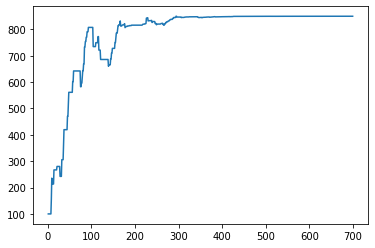

In [60]:
plt.plot(scores)
plt.show()
# better than previous one - robots have higher score after we trained like 200 times
# environment setting worked!

We see that the bot converges in less tries, say around 100 less, than our original model. This isn’t meant to be a controlled environment to compare both approaches, instead it’s about triggering thoughts on different ways of applying reinforced learning for discovery…